In [11]:
# Import necessary libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
from PIL import Image
import random
import pandas as pd

In [12]:
# Set device to GPU if available, else use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dice score metric for multi-class classification
def dice_score(preds, targets, epsilon=1e-6):
    preds = torch.softmax(preds, dim=1)                            # Apply softmax to get class probabilities
    preds = torch.argmax(preds, dim=1)                             # Get predicted class indices
    score = 0
    for cls in range(preds.max() + 1):                             # Loop through each class
        pred_inds = (preds == cls)                                 # Predicted mask for current class
        target_inds = (targets == cls)                             # Ground truth mask for current class
        intersection = (pred_inds & target_inds).sum().float()     # Compute intersection
        union = pred_inds.sum() + target_inds.sum() + epsilon      # Compute union with smoothing
        score += (2. * intersection / union)                       # Compute Dice for current class
    return score / (preds.max() + 1)                               # Average Dice score across classes

# Dice loss as 1 - Dice score
def dice_loss(preds, targets):
    return 1 - dice_score(preds, targets)

# Reverse normalization for visualization
def unnormalize(img_tensor):
    img = img_tensor.clone().detach()
    img = img * 0.5 + 0.5  # Reverse the normalization applied during preprocessing
    return img

In [13]:
# Define data paths and training parameters
train_path = "Extracted_Data/Training"
test_path = "Extracted_Data/Testing"
BATCH_SIZE = 16
EPOCHS = 10
SUBSET = False  # Whether to use a 10% subset of the training data

In [14]:
# Define basic preprocessing transforms (no augmentation)
transform_plain = transforms.Compose([
    transforms.Resize((224, 224)),                     # Resize all images to 224x224
    transforms.ToTensor(),                             # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)     # Normalize with mean and std deviation
])

# Load datasets using the defined transforms
train_data_plain = ImageFolder(root=train_path, transform=transform_plain)
test_data_plain = ImageFolder(root=test_path, transform=transform_plain)
class_names = train_data_plain.classes  # List of class labels

# Use a 10% subset of training data if SUBSET is enabled
if SUBSET:
    subset_size = int(0.1 * len(train_data_plain))
    train_data_plain, _ = random_split(train_data_plain, [subset_size, len(train_data_plain) - subset_size])

# Define DataLoaders for training and testing
train_loader_plain = DataLoader(train_data_plain, batch_size=BATCH_SIZE, shuffle=True)
test_loader_plain = DataLoader(test_data_plain, batch_size=BATCH_SIZE, shuffle=False)

# Load pretrained ResNet50 model
model_plain = models.resnet50(pretrained=True)  # Warning: 'pretrained' is deprecated
model_plain.fc = nn.Linear(model_plain.fc.in_features, 4)  # Modify final layer for 4 output classes
model_plain = model_plain.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model_plain.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [15]:
best_loss = float('inf')
patience = 2
patience_counter = 0

for epoch in range(EPOCHS):
    model_plain.train()
    loss_sum = 0

    for images, labels in train_loader_plain:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_plain(images)

        # Combined loss
        loss = criterion(outputs, labels) + dice_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()

    avg_loss = loss_sum / len(train_loader_plain)
    print(f"[RESNET50 - NoAug] Epoch {epoch+1}: Loss = {avg_loss:.4f}")

    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

[RESNET50 - NoAug] Epoch 1: Loss = 0.3249
[RESNET50 - NoAug] Epoch 2: Loss = 0.1383
[RESNET50 - NoAug] Epoch 3: Loss = 0.0864
[RESNET50 - NoAug] Epoch 4: Loss = 0.0501
[RESNET50 - NoAug] Epoch 5: Loss = 0.0364
[RESNET50 - NoAug] Epoch 6: Loss = 0.0531
[RESNET50 - NoAug] Epoch 7: Loss = 0.0471
Early stopping triggered.


In [16]:
# ------------------- Evaluation (No Augmentation) -------------------
y_true1, y_pred1, y_probs1 = [], [], []  # Store true labels, predictions, and probabilities

model_plain.eval()              # Set model to evaluation mode
with torch.no_grad():          # Disable gradient computation
    for images, labels in test_loader_plain:
        images = images.to(device)
        outputs = model_plain(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()  # Probabilities for ROC
        preds = np.argmax(probs, axis=1)                     # Predicted class
        
        y_true1.extend(labels.numpy())       # Ground truth labels
        y_pred1.extend(preds)                # Model predictions
        y_probs1.extend(probs)               # Prediction probabilities

# Print classification report for performance summary
print("\n--- Classification Report (No Augmentation) ---")
print(classification_report(y_true1, y_pred1, target_names=class_names))


--- Classification Report (No Augmentation) ---
              precision    recall  f1-score   support

      glioma       0.93      0.99      0.96       300
  meningioma       0.98      0.78      0.87       306
     notumor       0.88      1.00      0.93       405
   pituitary       1.00      0.94      0.97       300

    accuracy                           0.93      1311
   macro avg       0.95      0.93      0.93      1311
weighted avg       0.94      0.93      0.93      1311



In [17]:
# Calculate average Dice Score on test set
total_dice = 0
with torch.no_grad():
    for images, labels in test_loader_plain:
        images, labels = images.to(device), labels.to(device)
        outputs = model_plain(images)
        total_dice += dice_score(outputs, labels).item()

dice1 = total_dice / len(test_loader_plain)
print(f"Dice Score: {dice1:.4f}")

Dice Score: 0.4596


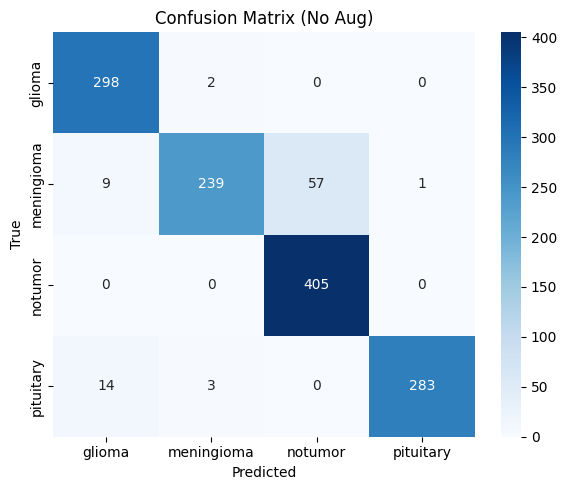

In [18]:
# Plot Confusion Matrix for evaluation
cm = confusion_matrix(y_true1, y_pred1)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (No Aug)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

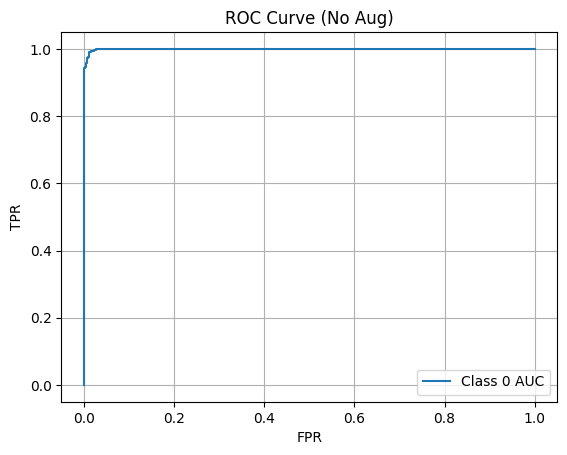

In [19]:
# Plot ROC Curve for Class 0
y_bin1 = label_binarize(y_true1, classes=list(range(4)))
fpr, tpr, _ = roc_curve(y_bin1[:, 0], np.array(y_probs1)[:, 0])
plt.plot(fpr, tpr, label="Class 0 AUC")
plt.title("ROC Curve (No Aug)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()
plt.legend()
plt.show()

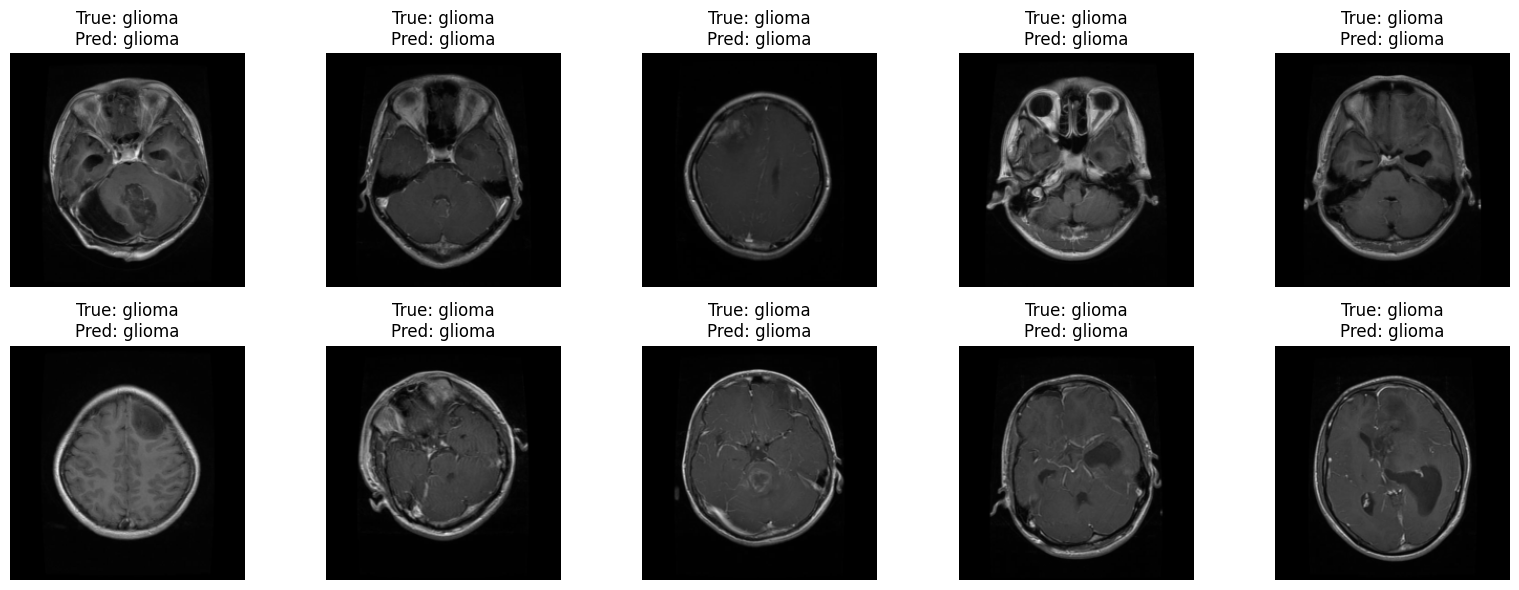

In [20]:
# Visualize 10 predictions with true and predicted class labels
fig, axs = plt.subplots(2, 5, figsize=(16, 6))
model_plain.eval()
for i in range(10):
    img, label = test_data_plain[i]
    img_disp = unnormalize(img)  # reverse normalization for display
    input_tensor = img.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model_plain(input_tensor)
        pred = output.argmax(dim=1).item()

    ax = axs[i//5, i%5]
    ax.imshow(img_disp.permute(1, 2, 0).numpy())
    ax.set_title(f'True: {class_names[label]}\nPred: {class_names[pred]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [21]:
class GradCAM:
    # Initialize the GradCAM object with model and target layer
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    # Register forward and backward hooks to capture activations and gradients
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    # Generate the Grad-CAM heatmap for the input image
    def generate_cam(self, input_image, class_idx=None):
        self.model.eval()
        output = self.model(input_image)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        target = output[:, class_idx]
        self.model.zero_grad()
        target.backward(retain_graph=True)

        # Calculate the weights and weighted combination of feature maps
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)

        # Apply ReLU, upsample to image size, normalize
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=input_image.shape[2:], mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam, class_idx


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


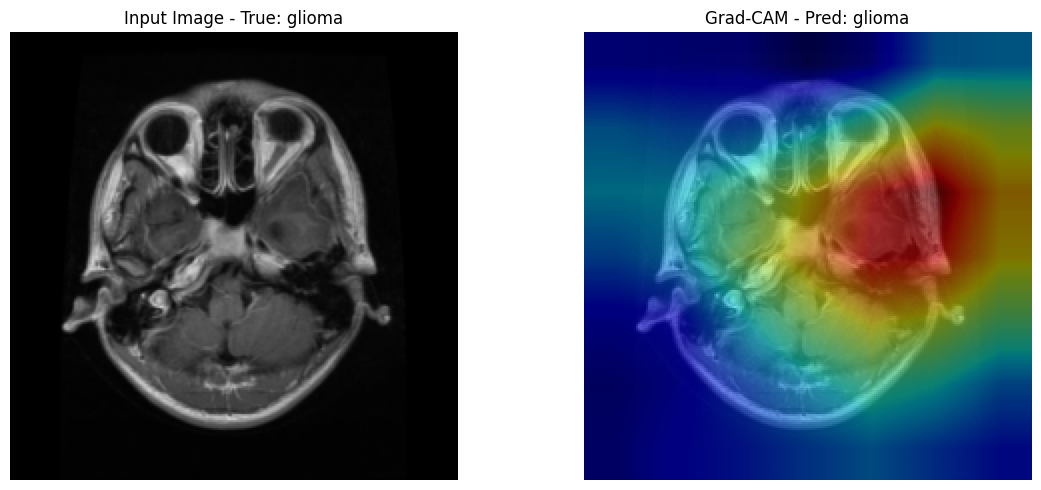

In [22]:
# Select a test image and send it to device
img, label = test_data_plain[3]
input_tensor = img.unsqueeze(0).to(device)

# Initialize Grad-CAM with the last convolutional layer
grad_cam = GradCAM(model_plain, model_plain.layer4[-1])

# Generate the heatmap and predicted class
cam, pred_class = grad_cam.generate_cam(input_tensor)

# Display original image and Grad-CAM overlay
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
img_disp = unnormalize(img)
plt.imshow(img_disp.permute(1, 2, 0).numpy())
plt.title(f'Input Image - True: {class_names[label]}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_disp.permute(1, 2, 0).numpy())
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title(f'Grad-CAM - Pred: {class_names[pred_class]}')
plt.axis('off')
plt.tight_layout()
plt.show()


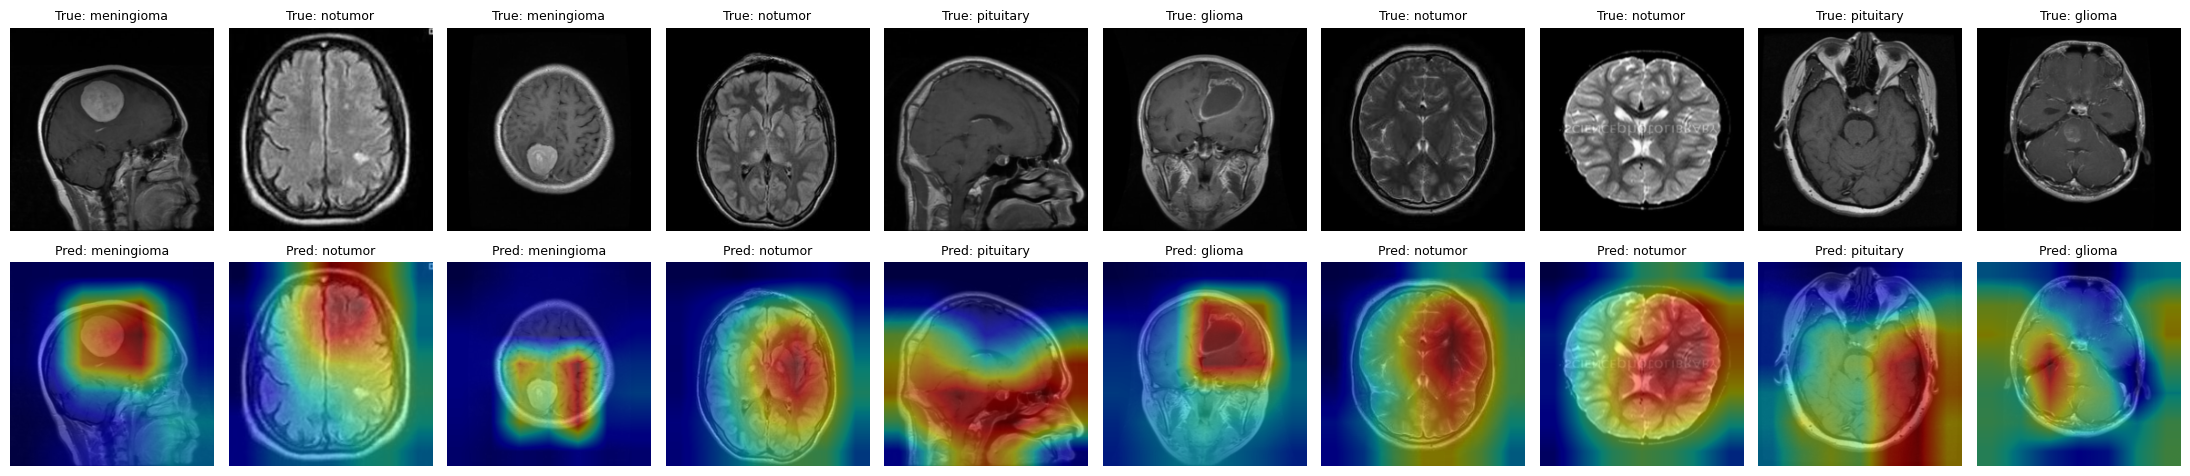

In [23]:
# Pick 10 random test images
indices = random.sample(range(len(test_data_plain)), 10)
grad_cam = GradCAM(model_plain, model_plain.layer4[-1])

fig, axs = plt.subplots(2, 10, figsize=(22, 5))

# Iterate through 10 images and show input + Grad-CAM overlay
for i, idx in enumerate(indices):
    img, label = test_data_plain[idx]
    input_tensor = img.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model_plain(input_tensor)
        pred_class = output.argmax(dim=1).item()

    cam, _ = grad_cam.generate_cam(input_tensor)
    img_disp = unnormalize(img)

    axs[0, i].imshow(img_disp.permute(1, 2, 0).numpy())
    axs[0, i].set_title(f'True: {class_names[label]}', fontsize=9)
    axs[0, i].axis('off')

    axs[1, i].imshow(img_disp.permute(1, 2, 0).numpy())
    axs[1, i].imshow(cam, cmap='jet', alpha=0.5)
    axs[1, i].set_title(f'Pred: {class_names[pred_class]}', fontsize=9)
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()


In [24]:
# Define image transformations with data augmentation
transform_aug = transforms.Compose([
    transforms.Resize((224, 224)),                # Resize image to 224x224
    transforms.RandomHorizontalFlip(),            # Random horizontal flip
    transforms.RandomRotation(10),                # Random rotation by ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Random brightness and contrast adjustment
    transforms.ToTensor(),                        # Convert image to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize tensor values to [-1, 1]
])

# Load training and testing datasets using the augmentation transformations
train_data_aug = ImageFolder(root=train_path, transform=transform_aug)
test_data_aug = ImageFolder(root=test_path, transform=transform_aug)

# Optional: use only 10% of training data (for faster experimentation)
if SUBSET:
    subset_size = int(0.1 * len(train_data_aug))
    train_data_aug, _ = random_split(train_data_aug, [subset_size, len(train_data_aug) - subset_size])

# Create data loaders for training and testing with augmentation
train_loader_aug = DataLoader(train_data_aug, batch_size=BATCH_SIZE, shuffle=True)
test_loader_aug = DataLoader(test_data_aug, batch_size=BATCH_SIZE, shuffle=False)

# Load pretrained ResNet50 model and adapt the final fully connected layer
model_aug = models.resnet50(pretrained=True)
model_aug.fc = nn.Linear(model_aug.fc.in_features, 4)  # Replace final layer to output 4 classes
model_aug = model_aug.to(device)

# Define optimizer
optimizer = torch.optim.Adam(model_aug.parameters(), lr=0.0001)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
# -------- Training Loop with data augmentation and Early Stopping --------
patience = 2
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(EPOCHS):
    model_aug.train()
    loss_sum = 0

    for images, labels in train_loader_aug:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_aug(images)
        loss = criterion(outputs, labels) + dice_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()

    avg_loss = loss_sum / len(train_loader_aug)
    print(f"[WITH AUG] Epoch {epoch+1}: Loss = {avg_loss:.4f}")

    # Early Stopping Check
    if avg_loss < best_loss:
        best_loss = avg_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break


[WITH AUG] Epoch 1: Loss = 0.3892
[WITH AUG] Epoch 2: Loss = 0.1636
[WITH AUG] Epoch 3: Loss = 0.1263
[WITH AUG] Epoch 4: Loss = 0.0757
[WITH AUG] Epoch 5: Loss = 0.0893
[WITH AUG] Epoch 6: Loss = 0.0431
[WITH AUG] Epoch 7: Loss = 0.0606
[WITH AUG] Epoch 8: Loss = 0.0701
Early stopping triggered at epoch 8


In [26]:
# Evaluate model performance on test set with augmentation
y_true2, y_pred2, y_probs2 = [], [], []
model_aug.eval()
with torch.no_grad():
    for images, labels in test_loader_aug:
        images = images.to(device)
        outputs = model_aug(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        y_true2.extend(labels.numpy())
        y_pred2.extend(preds)
        y_probs2.extend(probs)

# Print classification report
print("\n--- Classification Report (With Augmentation) ---")
print(classification_report(y_true2, y_pred2, target_names=class_names))


--- Classification Report (With Augmentation) ---
              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       300
  meningioma       0.99      0.92      0.95       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



In [27]:
# Calculate Dice Score on test set with augmentation
total_dice = 0
with torch.no_grad():
    for images, labels in test_loader_aug:
        images, labels = images.to(device), labels.to(device)
        outputs = model_aug(images)
        total_dice += dice_score(outputs, labels).item()
dice2 = total_dice / len(test_data_aug)
print(f"Dice Score: {dice2:.4f}")

Dice Score: 0.0290


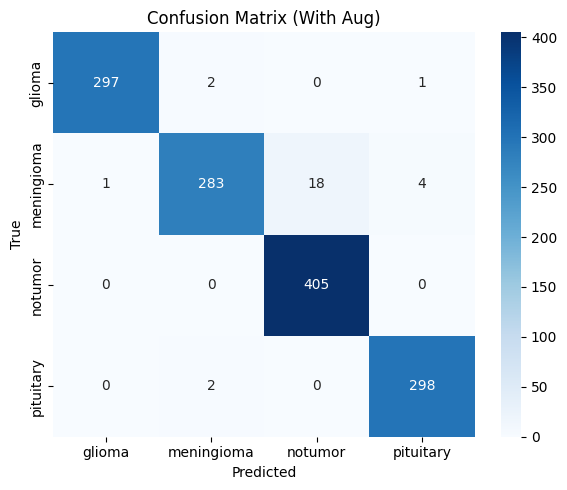

In [28]:
# Plot confusion matrix for augmented model predictions
cm = confusion_matrix(y_true2, y_pred2)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (With Aug)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

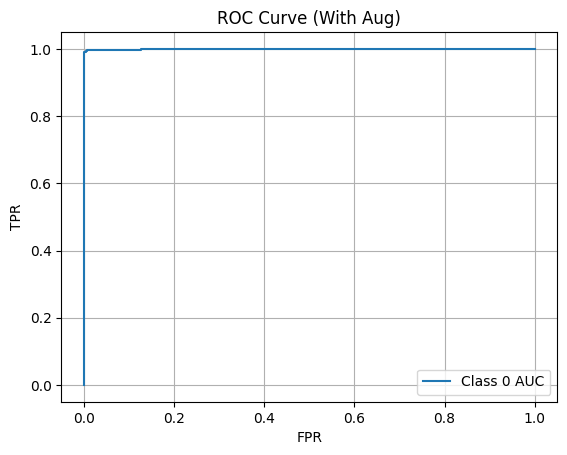

In [29]:
# Plot ROC curve for the augmented model 
y_bin2 = label_binarize(y_true2, classes=list(range(4)))
fpr, tpr, _ = roc_curve(y_bin2[:, 0], np.array(y_probs2)[:, 0])
plt.plot(fpr, tpr, label="Class 0 AUC")
plt.title("ROC Curve (With Aug)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()
plt.legend()
plt.show()

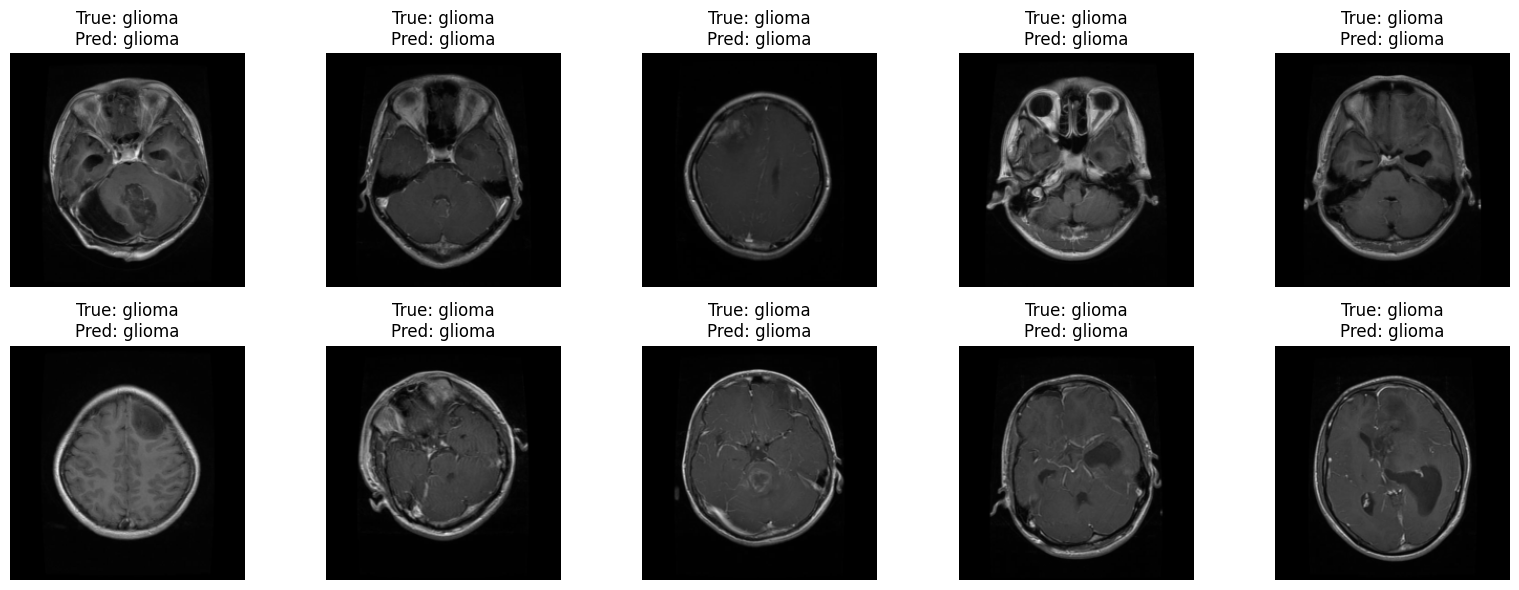

In [30]:
# Visualize 10 predictions with true and predicted class labels
fig, axs = plt.subplots(2, 5, figsize=(16, 6))
model_plain.eval()
for i in range(10):
    img, label = test_data_plain[i]
    img_disp = unnormalize(img)   # reverse normalization for display
    input_tensor = img.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model_plain(input_tensor)
        pred = output.argmax(dim=1).item()
        
    ax = axs[i//5, i%5]
    ax.imshow(img_disp.permute(1, 2, 0).numpy())
    ax.set_title(f'True: {class_names[label]}\nPred: {class_names[pred]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


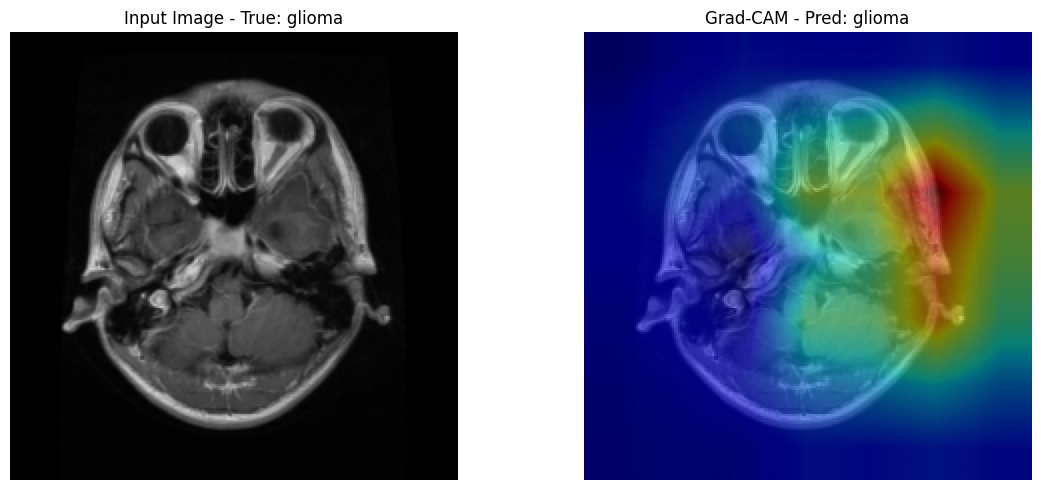

In [31]:
# Visualize single Grad-CAM sample using augmented model
img, label = test_data_plain[3]
input_tensor = img.unsqueeze(0).to(device)

# Initialize Grad-CAM with the last convolutional layer
grad_cam = GradCAM(model_aug, model_aug.layer4[-1])

# Generate the heatmap and predicted class
cam, pred_class = grad_cam.generate_cam(input_tensor)

# Display original image and Grad-CAM overlay
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
img_disp = unnormalize(img)
plt.imshow(img_disp.permute(1, 2, 0).numpy())
plt.title(f'Input Image - True: {class_names[label]}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_disp.permute(1, 2, 0).numpy())
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title(f'Grad-CAM - Pred: {class_names[pred_class]}')
plt.axis('off')
plt.tight_layout()
plt.show()

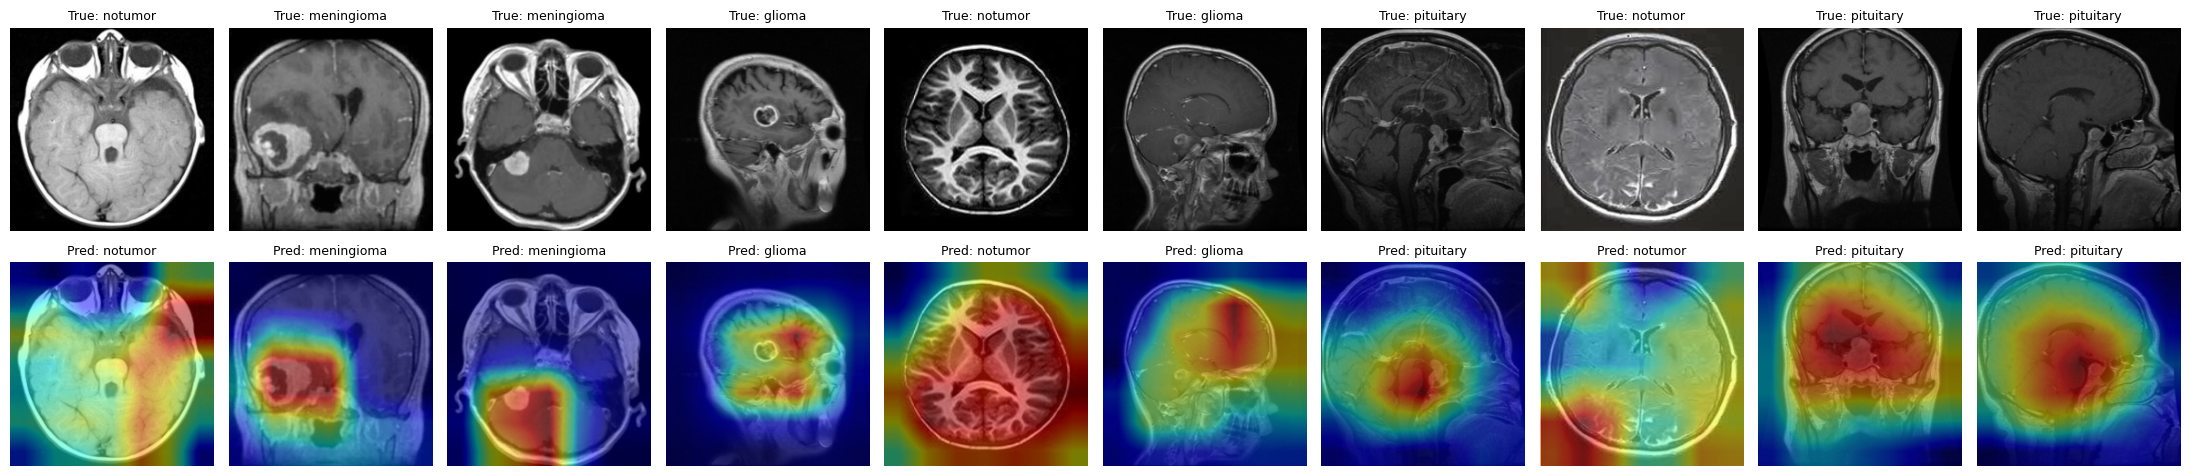

In [32]:
# Visualize Grad-CAM for 10 random samples using augmented model
indices = random.sample(range(len(test_data_plain)), 10)
grad_cam = GradCAM(model_aug, model_aug.layer4[-1])

fig, axs = plt.subplots(2, 10, figsize=(22, 5))
for i, idx in enumerate(indices):
    img, label = test_data_plain[idx]
    input_tensor = img.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model_aug(input_tensor)
        pred_class = output.argmax(dim=1).item()
    cam, _ = grad_cam.generate_cam(input_tensor)
    img_disp = unnormalize(img)

    axs[0, i].imshow(img_disp.permute(1, 2, 0).numpy())
    axs[0, i].set_title(f'True: {class_names[label]}', fontsize=9)
    axs[0, i].axis('off')

    axs[1, i].imshow(img_disp.permute(1, 2, 0).numpy())
    axs[1, i].imshow(cam, cmap='jet', alpha=0.5)
    axs[1, i].set_title(f'Pred: {class_names[pred_class]}', fontsize=9)
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

In [33]:
# Create a comparison DataFrame to evaluate the performance of the model
# with and without data augmentation using multiple metrics.
df_compare = pd.DataFrame({
    
    # Define the names of the metrics to be compared
    "Metric": [
        "Accuracy",                # Overall correctness of the model's predictions
        "Dice Score",              # Overlap measure between predicted and true labels
        "AUC Score",               # Area Under the ROC Curve (macro-averaged)
        "Precision (macro)",       # Macro-averaged precision across all classes
        "Recall (macro)",          # Macro-averaged recall across all classes
        "F1 Score (macro)"         # Macro-averaged F1 score
    ],

    # Metric values for the model trained without data augmentation
    "No Augmentation": [
        classification_report(y_true1, y_pred1, output_dict=True)['accuracy'], # Accuracy
        dice1,                                                                 # Dice Score
        roc_auc_score(label_binarize(y_true1, classes=list(range(4))), 
                      y_probs1, average='macro'),                              # AUC Score
        precision_score(y_true1, y_pred1, average='macro'),                    # Precision
        recall_score(y_true1, y_pred1, average='macro'),                       # Recall
        f1_score(y_true1, y_pred1, average='macro')                            # F1 Score
    ],

    # Metric values for the model trained with data augmentation
    "With Augmentation": [
        classification_report(y_true2, y_pred2, output_dict=True)['accuracy'],  # Accuracy
        dice2,                                                                  # Dice Score
        roc_auc_score(label_binarize(y_true2, classes=list(range(4))), 
                      y_probs2, average='macro'),                               # AUC Score
        precision_score(y_true2, y_pred2, average='macro'),                    # Precision
        recall_score(y_true2, y_pred2, average='macro'),                       # Recall
        f1_score(y_true2, y_pred2, average='macro')                            # F1 Score
    ]
})

# Print the final comparative table
print(df_compare)


              Metric  No Augmentation  With Augmentation
0           Accuracy         0.934401           0.978642
1         Dice Score         0.459630           0.028968
2          AUC Score         0.984450           0.999368
3  Precision (macro)         0.945240           0.980913
4     Recall (macro)         0.929428           0.977042
5   F1 Score (macro)         0.933067           0.978608


In [34]:
# Generate detailed classification reports for each class
# 'output_dict=True' returns the metrics in dictionary format for easier access
report_no_aug = classification_report(y_true1, y_pred1, target_names=class_names, output_dict=True)
report_aug = classification_report(y_true2, y_pred2, target_names=class_names, output_dict=True)

# Create a DataFrame to store per-class metric comparisons
df_per_class = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1-score", "Support"],  # Define metric labels
})

# Loop through each class name and extract the corresponding metrics
for cls in class_names:
    # Append metrics for the no-augmentation model
    df_per_class[f"{cls} (No Aug)"] = [
        report_no_aug[cls]["precision"],     # Class-specific precision
        report_no_aug[cls]["recall"],        # Class-specific recall
        report_no_aug[cls]["f1-score"],      # Class-specific F1-score
        report_no_aug[cls]["support"],       # Number of true instances for this class
    ]
    
    # Append metrics for the augmentation model
    df_per_class[f"{cls} (With Aug)"] = [
        report_aug[cls]["precision"],
        report_aug[cls]["recall"],
        report_aug[cls]["f1-score"],
        report_aug[cls]["support"],
    ]

# Set the precision for floating point values in the printed DataFrame
pd.set_option('display.precision', 3)

# Display the per-class comparison table
print(df_per_class)


      Metric  glioma (No Aug)  glioma (With Aug)  meningioma (No Aug)  \
0  Precision            0.928              0.997                0.980   
1     Recall            0.993              0.990                0.781   
2   F1-score            0.960              0.993                0.869   
3    Support          300.000            300.000              306.000   

   meningioma (With Aug)  notumor (No Aug)  notumor (With Aug)  \
0                  0.986             0.877               0.957   
1                  0.925             1.000               1.000   
2                  0.954             0.934               0.978   
3                306.000           405.000             405.000   

   pituitary (No Aug)  pituitary (With Aug)  
0               0.996                 0.983  
1               0.943                 0.993  
2               0.969                 0.988  
3             300.000               300.000  
